<a href="https://colab.research.google.com/github/justinye0617/carPrices/blob/main/carPrices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Car Price Prediction Model

In [23]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
data = pd.read_csv('data/vehicles.csv')
data.shape, data.columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [24]:
#drop columns with more than 25% missing values
missing_threshold = 0.25
null_cols = data.columns[data.isna().mean() > missing_threshold]
data = data.drop(columns = null_cols)

#drop high cardinality columns
high_card_cols = [col for col in data.select_dtypes(include = 'object').columns if data[col].nunique() > 100]
data = data.drop(columns = high_card_cols)

#drop irrelevant columns
data = data.drop(columns = ['id', 'VIN'], errors = 'ignore')
data.columns


Index(['price', 'year', 'manufacturer', 'fuel', 'odometer', 'title_status',
       'transmission', 'type', 'state'],
      dtype='object')

In [25]:
#remove price outliers
data = data[(data['price'] > 500) & (data['price'] < 100000)]

#create car_age and drop year
data['car_age'] = 2025 - data['year']
data = data.drop(columns = ['year'], errors = 'ignore')

#log-transform price
data['log_price'] = np.log1p(data['price'])

In [26]:
#fill missing numeric columns with mean
for col in data.select_dtypes(include = ['number']).columns:
    if data[col].isna().sum() > 0:
        data[col] = data[col].fillna(data[col].mean())

#fill missing categorical values with 'missing'
for col in data.select_dtypes(include = 'object').columns:
    if data[col].isna().sum() > 0:
        data[col] = data[col].fillna('missing')

In [27]:
#one-hot encode categorical variables
data = pd.get_dummies(data, drop_first = True)

In [28]:
X = data.drop(columns=['price', 'log_price'])
y = data['log_price']

#standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.3, random_state = 42)


In [29]:
#linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)

#lightGBM
lgbm = lgb.LGBMRegressor(
    boosting_type = 'gbdt',
    num_leaves = 64,
    n_estimators = 300,
    learning_rate = 0.05,
    random_state = 42
)
lgbm.fit(X_train, y_train)
lgb_preds = lgbm.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.221112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 704
[LightGBM] [Info] Number of data points in the train set: 268147, number of used features: 117
[LightGBM] [Info] Start training from score 9.541560


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [30]:
#clip predictions to avoid overflow
lr_preds = np.clip(lr_preds, 0, 15)
lgb_preds = np.clip(lgb_preds, 0, 15)

#back-transform
true_prices = np.expm1(y_test)
lr_prices = np.expm1(lr_preds)
lgb_prices = np.expm1(lgb_preds)

print("Linear Regression RMSE:", np.sqrt(mean_squared_error(true_prices, lr_prices)))
print("LightGBM RMSE:", np.sqrt(mean_squared_error(true_prices, lgb_prices)))
print("Linear Regression R^2:", r2_score(true_prices, lr_prices))
print("LightGBM R^2:", r2_score(true_prices, lgb_prices))


Linear Regression RMSE: 10999.108940257353
LightGBM RMSE: 7434.750342400589
Linear Regression R^2: 0.41783645945152736
LightGBM R^2: 0.7340115520979659


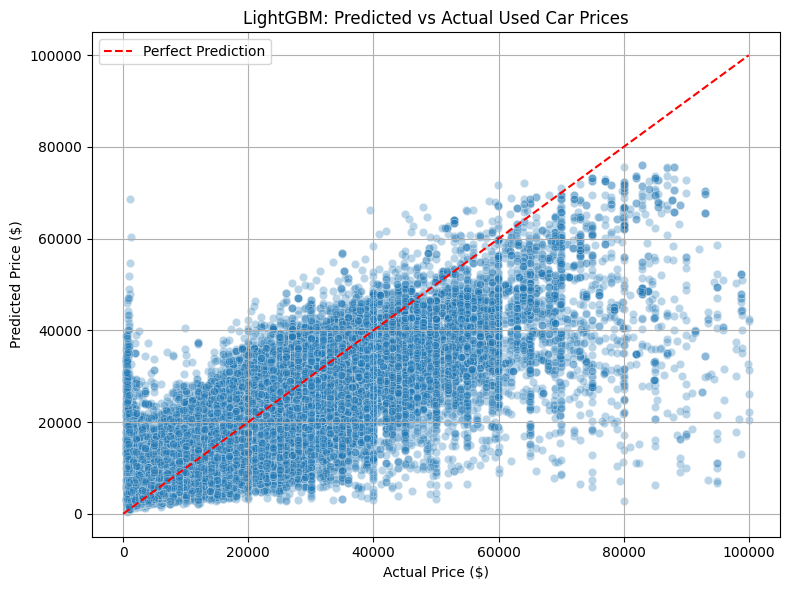

In [31]:
#plot
plt.figure(figsize = (8, 6))
sns.scatterplot(x = true_prices, y = lgb_prices, alpha = 0.3)
plt.plot([0, 100000], [0, 100000], 'r--', label = 'Perfect Prediction')
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title("LightGBM: Predicted vs Actual Used Car Prices")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
